<span style="font-family: 'Avenir'; font-size: 18px; line-height: 1.5;">

**CopperMap:** Enhancing Success in Ullmann Couplings

</span>

<span style="font-family: 'Avenir'; font-size: 18px; line-height: 1.5;">    
    
For comprehensive details about the experimental, computational, and modeling aspects, please refer to our manuscript on [ChemRxiv](https://chemrxiv.org/engage/chemrxiv/article-details/6532eb5cc3693ca993c1ce40).

</span>


<span style="font-family: 'Avenir'; font-size: 15px; line-height: 1.5;">  
    
M. Samha,# L. Karas,# D. Vogt, E. Odogwu, J. Elward, J. Crawford, J. Steves, M. Sigman. Predicting Success in Cu-Catalyzed C–N Coupling Reactions using Data Science. ChemRxiv, 2023. DOI: 10.26434/chemrxiv-2023-f50w6.

</span>

<span style="font-family: 'Avenir'; font-size: 18px; line-height: 1.5;">  
    
**Key Features:**
- **Target Reaction:** CopperMap was trained for predicting combinations of primary amines and aryl-bromides in Ullmann couplings.
- **Average Accuracy:** CopperMap achieved an average accuracy of 89% in predicting on/off reactivity (below or above 20% yield) using a dataset of approximately 1000 data points.
- **Library Composition:** The compound library includes 497 primary amines and 385 aryl-bromides.
- **Customization:** If your desired substrate is not in the library, consider simplifying the search by focusing on the amine or aryl-bromide core only.

</span>

<span style="font-family: 'Avenir'; font-size: 18px; line-height: 1.5;">    

Developed by [The Sigman Lab](https://www.sigmanlab.com).
Developer: Lucas Karas 
</span>

# IMPORTS

In [1]:
import sys
import os

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools, AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import Image, display

import pickle
from sklearn.neighbors import NearestNeighbors

import warnings

# SET MATPLOTLIB STANDARDS:

matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 10

# HELPER FUNCTIONS

In [2]:
# Function to load pickle files
def load_pickle(file_path, folder_path="imports"):
    """
    Loads DataFrames, dictionaries, and trained models from a .pkl file.

    Parameters:
    - file_path (str): The file name or relative path of the .pkl file.
    - folder_path (str): The folder where the .pkl file is located. Default is "import".

    Returns:
    - Any: The loaded file object.
    """
    # Combine folder_path and file_path
    full_path = os.path.join(folder_path, file_path)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        with open(full_path, 'rb') as file:
            return pickle.load(file)
# Function to convert a given SMILES string to isomeric SMILES
def convert_to_isomeric_smiles(smiles):
    """
    Uses RDKit, a cheminformatics toolkit, to convert the entered SMILES string into isomeric SMILES.

    Parameters:
    - smiles (str): The SMILES string to convert.

    Returns:
    - str: The isomeric SMILES representation of the input molecule.
    """
    mol = Chem.MolFromSmiles(smiles)
    isomeric_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    return isomeric_smiles
# Function to get the substrates smiles
def get_input(smiles_type, substrate_dataframe, property_substrate):
    """
    Obtains user input for a SMILES string, converts it to isomeric SMILES,
    and retrieves a relevant property value from the specified DataFrame.

    Parameters:
    - smiles_type (str): Type of substrate (e.g., "primary amine", "aryl-bromide").
    - substrate_dataframe (pd.DataFrame): DataFrame containing substrate information.
    - property_substrate (str): Name of the property to retrieve from the DataFrame.

    Returns:
    - tuple: A tuple containing the entered isomeric SMILES and the corresponding property value.
    """

    while True:
        # Prompt the user to enter a SMILES string
        input_string = input(f"Enter SMILES string of a {smiles_type} in the library: ")
        
        # Convert the entered SMILES to isomeric SMILES
        input_smiles = convert_to_isomeric_smiles(input_string)
        
        # Initialize pred to an empty list
        pred = []
        
        try:
            # Try to find the relevant value for the entered isomeric SMILES in the DataFrame
            pred = substrate_dataframe.loc[substrate_dataframe['smiles'] == input_smiles, property_substrate].values[0]
            print(f"The value for the entered compound: {pred}")
            break  # Exit the loop if a valid SMILES is entered
        except IndexError:
            # Handle the case where the entered SMILES is not found in the library
            print(f"{smiles_type} not found in the library.")
            retry = input("Do you want to try again? [yes/no]: ")
            if retry.lower() != 'yes' and retry.lower() != 'y':
                print("Exiting the program.")
                sys.exit()
            else:
                continue  # Ask for input again if the user wants to retry
        
    # Check if pred is a valid numeric value
    if not isinstance(pred, (int, float)):
        print(f"No {smiles_type} entered. Exiting the program.")
        sys.exit()
    
    return input_smiles, pred
# Function to plot the smiles structure
def display_structure(smiles_type, smiles, substrate_dataframe):
    """
    Displays the molecular structure of the entered smiles strings.

    Parameters:
    - smiles_type (str): Type of substrate (e.g., "primary amine", "aryl-bromide").
    - smiles (str): Isomeric SMILES representation of the entered compound.
    - substrate_dataframe (pd.DataFrame): DataFrame containing substrate information.

    Returns:
    - plt: RDKit plot of the entered smiles
    """

    mol = Chem.MolFromSmiles(smiles)
    plt_mol = Chem.Draw.MolToImage(mol, size=(150, 150), sanitize=False)

    # Display the structure of the entered compound
    print(f"{smiles_type.capitalize()} structure:")
    display(plt_mol)

# Function to normalize the amine_pred and br_pred values
def normalize_and_stack(amine_pred, br_pred, loaded_x_values, loaded_y_values):
    """
    Normalize and stack the target coordinates to create input data for machine learning models.

    Parameters:
    - amine_pred (float): N𝛿– value for the entered primary amine
    - br_pred (float): Steric value for the entered aryl-bromide
    - loaded_x_values (tuple): Tuple containing min and max values for x-axis normalization.
    - loaded_y_values (tuple): Tuple containing min and max values for y-axis normalization.

    Returns:
    - x_target_norm (float): Normalized value of the N𝛿– value for the entered primary amine
    - y_target_norm (float): Normalized value of the Steric value for the entered aryl-bromide
    - input_data (numpy.ndarray): Stacked normalized coordinates as input data.
    """
    # Convert predictions to NumPy arrays
    X = np.array([amine_pred])
    Y = np.array([br_pred])

    # Normalize the target coordinates
    x_target_norm = (X - loaded_x_values[0]) / (loaded_x_values[1] - loaded_x_values[0])
    y_target_norm = (Y - loaded_y_values[0]) / (loaded_y_values[1] - loaded_y_values[0])

    # Stack the normalized coordinates to create input data
    input_data = np.column_stack((x_target_norm, y_target_norm))

    return x_target_norm, y_target_norm, input_data
# Function to get the confidence value for the entered coupling partners
def get_confidence_prediction(x_target_norm, y_target_norm, confidence_model):
    """
    Get confidence predictions for the entered coupling partners using the interpolation model.

    Parameters:
    - x_target_norm (float):  Normalized value of the N𝛿– value for the entered primary amine
    - y_target_norm (float): Normalized value of the Steric value for the entered aryl-bromide
    - confidence_model (callable): Model for predicting confidence.

    Returns:
    - confidence_pred (numpy.ndarray): Prediction (below or above 20%) and the confidence value
    - message (str): Message describing the prediction results.
    """
    # Make predictions with the confidence model
    confidence_pred = confidence_model(x_target_norm, y_target_norm)

    # Display prediction results
    if confidence_pred[0] < 0:
        message = f'Predicted yield for this reaction is \033[1m<20% with {-confidence_pred[0]:.1f}% confidence.\033[0m'
    else: 
        message = f'Predicted yield for this reaction is \033[1m>20% with {confidence_pred[0]:.1f}% confidence.\033[0m'

    print(message)
    return confidence_pred, message
# Function to find the nearest neighbors 
def get_nearest_neighbors(input_data, knn_model, training_dict):
    """
    Get information about the nearest neighbors using the k-nearest neighbors model.

    Parameters:
    - input_data (numpy.ndarray): Input data for which nearest neighbors are sought.
    - knn_model (object): k-nearest neighbors model.
    - training_dict (dict): Dictionary containing information about products in the training set.

    Returns:
    - P1 (str): Product ID for the first nearest neighbor.
    - P1_info (dict): Information about the first nearest neighbor.
    - P2 (str): Product ID for the second nearest neighbor.
    - P2_info (dict): Information about the second nearest neighbor.
    """
    # Find the nearest neighbors and their distances
    distances, indices = knn_model.kneighbors(input_data)

    # Define product IDs for the first and second nearest neighbors
    P1 = f'P{100 + indices[0][0]}'
    P1_info = training_dict[P1]
    P2 = f'P{100 + indices[0][1]}'
    P2_info = training_dict[P2]

    return P1, P1_info, P2, P2_info
# Function to plot the confidence contour map
def plot_confidence_contour(x_grid, y_grid, input_data, confidence_pred):
    """
    Plot the confidence contour and the nearest neighbors.

    Parameters:
    - x_grid (numpy.ndarray): X-coordinates for the meshgrid.
    - y_grid (numpy.ndarray): Y-coordinates for the meshgrid.
    - confidence_model (function): Model for predicting confidence values.
    - input_data (numpy.ndarray): Input data points.
    - confidence_pred (numpy.ndarray): Confidence predictions.
    - P1_info (dict): Information about the first nearest neighbor.
    - P2_info (dict): Information about the second nearest neighbor.
    """
    plt.close()

    # Calculate confidence values on the meshgrid
    confidence_interp = confidence_model(x_grid, y_grid)
    # Clip confidence values to a reasonable range
    confidence_interp_norm = np.clip(confidence_interp, -100, 100)
    # Extract normalized coordinates of the nearest neighbors
    X_NN = np.array([P1_info['Normalized_N𝛿–'], P2_info['Normalized_N𝛿–']])
    Y_NN = np.array([P1_info['Normalized_Steric'], P2_info['Normalized_Steric']])
    neighbors_data = np.column_stack((X_NN, Y_NN))

    # Plot the confidence contour and data points
    plt.figure(figsize=(3, 3))
    contour = plt.contourf(x_grid, y_grid, confidence_interp_norm, cmap='RdBu', levels=100)
    scatter = plt.scatter(input_data[:, 0], input_data[:, 1], c=confidence_pred, cmap='RdBu', marker='X', s=75, edgecolors='black', linewidth=1, vmin=-1, vmax=1)
    scatter = plt.scatter(neighbors_data[:, 0], neighbors_data[:, 1], marker='o', s=10, color='black', linewidth=1)
    plt.xlabel('Amine [Normalized N$^\delta$$^–$]')
    plt.ylabel('Aryl-Bromide [Normalized Steric]')
    
    plt.show()
    
# Function to display the best ligands information
def display_ligands_info(neighbor, P1_info, P2_info, ligands):
    """
    Display information about the unique top ligands between two nearest neighbors.

    Parameters:
    - P1_info (dict): Information about the first product, including top ligands.
    - P2_info (dict): Information about the second product, including top ligands.
    - ligands (dict): Dictionary mapping ligand names to PubChem links.
    """
    # Extract the names of top ligands from both P1 and P2
    ligands_P1 = {P1_info[f'Top_{i}_Ligand'] for i in range(1, 4)}
    ligands_P2 = {P2_info[f'Top_{i}_Ligand'] for i in range(1, 4)}

    # Find the unique ligands between P1 and P2
    unique_ligands = ligands_P1 | ligands_P2

    # Ensure there are spots for 6 ligands
    unique_ligands |= {f'Empty_{i}' for i in range(1, 7 - len(unique_ligands))}

    # Create an empty grid for ligands
    ligand_grid = [['Empty' for _ in range(3)] for _ in range(2)]

    # Populate the grid with ligands
    row, col = 0, 0
    for ligand in unique_ligands:
        # Check if the ligand is empty
        if ligand.startswith('Empty'):
            continue

        # Get the SMILES for the ligand
        smiles = ligands_df.loc[ligands_df['Compound_Name'] == ligand, 'smiles'].values[0]

        # Create a Mol object from SMILES
        mol = Chem.MolFromSmiles(smiles)

        # Assign ligand to the grid
        ligand_grid[row][col] = {'ligand': ligand, 'mol': mol}

        # Move to the next position in the grid
        col += 1
        if col == 3:
            col = 0
            row += 1

    # Display the ligands in the grid
    fig, axs = plt.subplots(2, 3, figsize=(10, 4))

    for row in range(2):
        for col in range(3):
            ligand_data = ligand_grid[row][col]

            # Check if the ligand is empty
            if ligand_data == 'Empty':
                axs[row, col].axis("off")
                continue

            # Display ligand image
            axs[row, col].imshow(Chem.Draw.MolToImage(ligand_data['mol'], size=(400, 150), sanitize=False))
            axs[row, col].text(0.5, -0.1, f"{ligand_data['ligand']}", ha='center', va='center',
                               transform=axs[row, col].transAxes, fontsize=10)
            axs[row, col].axis("off")

    plt.show()

    print(f"Here are PubChem links for those ligands:")
    for ligand in unique_ligands:
        if "Ligand" in ligand:
            print(f"L{int(ligand.split('_')[1])}: {ligands[ligand]}")

# Function to get information about the top ligands for a given product
def get_ligands_info(info_dict, num_top_ligands=3):
    """
    Extracts information about the top ligands and their yields from a given product (info_dict, e.g., P1_info).

    Parameters:
    - info_dict (dict): A dictionary containing information about ligands and yields.
    - num_top_ligands (int): The number of top ligands to retrieve (default is 3).

    Returns:
    - ligands_info (list): A list of tuples containing information about each top ligand.
                          Each tuple contains (ligand_label, ligand_info, yield_info).
    """
    ligands_info = []

    # Loop through the specified number of top ligands
    for i in range(1, num_top_ligands + 1):
        ligand_key = f'Top_{i}_Ligand'
        yield_key = f'Top_{i}_Yield'

        # Extract ligand number from the ligand key
        ligand_number = int(info_dict[ligand_key].split('_')[1])

        # Append ligand information to the ligands_info list
        ligands_info.append((f"L{ligand_number}", info_dict[ligand_key], info_dict[yield_key]))

    # Return the list of ligands_info
    return ligands_info

# Function to print ligand name and yields for a product
def print_product_info(product_name, ligands_info, neighbor_number):
    """
    Prints information about the nearest known product and its best ligands.

    Parameters:
    - product_name (str): The name of the nearest known product.
    - ligands_info (list): A list of tuples containing information about the best ligands.
    - neighbor_number (int): The number of the nearest neighbor (1 for the first, 2 for the second).

    Returns:
    - None
    """
    # Determine the neighbor name based on the neighbor number
    neighbor_name = "" if neighbor_number == 1 else "second "

    # Print information about the nearest known product and its best ligands
    print(f"\nThe {neighbor_name}nearest known product is {product_name}. "
          f"Best ligands for this product are:\n"
          f"{ligands_info[0][0]} [{ligands_info[0][2]}% yield], "
          f"{ligands_info[1][0]} [{ligands_info[1][2]}% yield], "
          f"and {ligands_info[2][0]} [{ligands_info[2][2]}% yield]."
    )

# Function to plot the reaction between the coupling partners
def draw_reaction_image(amine_smiles, br_smiles):
    """
    Draws a chemical reaction with reactants and products and displays the image.

    Parameters:
    - amine_smiles (str): SMILES representation of the amine reactant.
    - br_smiles (str): SMILES representation of the bromide reactant.

    Returns:
    - None
    """
    # Define the reaction SMARTS
    reaction_smarts = '[N:1].[c:2]-Br>>[c:2]-[N:1]'

    # Create an RDKit reaction from SMARTS
    rxn = AllChem.ReactionFromSmarts(reaction_smarts)

    # Run the reaction
    ps = rxn.RunReactants((Chem.MolFromSmiles(amine_smiles), Chem.MolFromSmiles(br_smiles)))

    # Get the SMILES of the product
    product_smiles = Chem.MolToSmiles(ps[0][0])

    # Create RDKit molecule from product SMILES
    product_mol = Chem.MolFromSmiles(product_smiles)

    # Create RDKit reaction from SMILES
    rxn_prod = AllChem.ReactionFromSmarts(f'{amine_smiles}.{br_smiles}>{"[Cu]"}>{product_smiles}', useSmiles=True)

    # Draw the reaction with reactants and product
    d2d = Draw.MolDraw2DCairo(500, 300)
    d2d.drawOptions().minFontSize = 15
    d2d.DrawReaction(rxn_prod)
    d2d.FinishDrawing()

    # Get the PNG image
    png = d2d.GetDrawingText()

    # Display the image
    display(Image(png))


# LOAD PICKLE FILES

In [3]:
# Load min and max values for normalization
loaded_x_values, loaded_y_values = load_pickle('min_max_values.pkl')
# Load the confidence model
confidence_model = load_pickle('confidence_model.pkl')
# Load the k-nearest neighbors model
knn_model = load_pickle('knn_model.pkl')
# Load the best ligands data
best_ligands = load_pickle('best_ligands.pkl')
# Load grid data (x and y values)
x_grid, y_grid = load_pickle('grid_data.pkl')
# Load a dictionary containing training data
training_dict = load_pickle('training_dict.pkl')
# Read substrates and ligands DataFrames from pickle
br_df = load_pickle('br_df.pkl')
amine_df = load_pickle('amine_df.pkl')
ligands_df = load_pickle('ligands_df.pkl')
# Load pubchem links for ligands
ligands = load_pickle('pubchem_lig.pkl')

# PREDICTION TOOL

-----------------------------------------------------------------------------------
-                      ~ Prediction tool for Ullmann couplings ~                  -
-----------------------------------------------------------------------------------
Enter SMILES string of a primary amine in the library: NC1=CC=CC=C1
The value for the entered compound: -0.79202
Enter SMILES string of a aryl-bromide in the library: BrC1=CC=CC=C1
The value for the entered compound: 30.5476

Entered substrates and expected product:


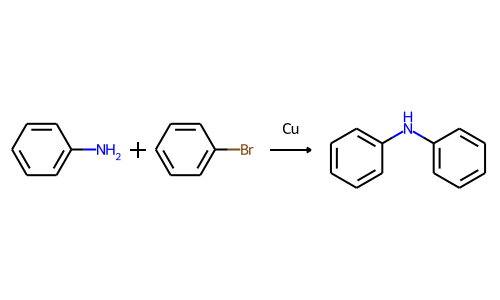

Predicted yield for this reaction is <20% with 95.0% confidence.


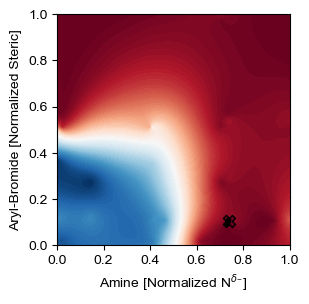

-----------------------------------------------------------------------------------
-                           ~ Ligand Suggestion Tool ~                            -
-----------------------------------------------------------------------------------

The nearest known product is P110. Best ligands for this product are:
L30 [17.7% yield], L28 [16.8% yield], and L26 [14.1% yield].

The second nearest known product is P118. Best ligands for this product are:
L28 [8.1% yield], L26 [6.7% yield], and L32 [5.4% yield].

Based on that, here are the ligands we suggest trying for this reaction:


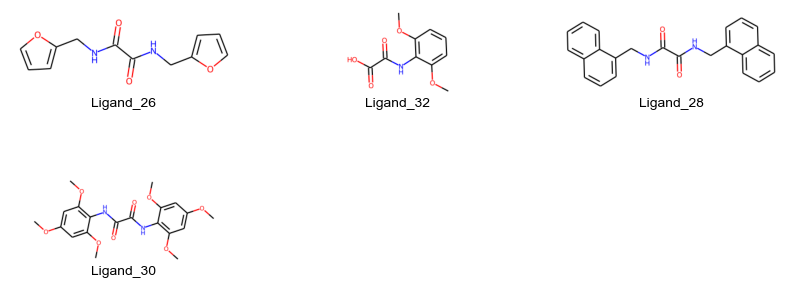

Here are PubChem links for those ligands:
L26: https://pubchem.ncbi.nlm.nih.gov/compound/330826
L32: https://pubchem.ncbi.nlm.nih.gov/compound/118864503
L28: https://pubchem.ncbi.nlm.nih.gov/compound/145722499
L30: https://pubchem.ncbi.nlm.nih.gov/compound/126500457


In [4]:
print(f"-----------------------------------------------------------------------------------")
print(f"-                      ~ Prediction tool for Ullmann couplings ~                  -")
print(f"-----------------------------------------------------------------------------------")

# # INPUT SMILES FOR PRIMARY AMINE AND ARYL-BROMIDE:

# Primary amine input loop:
amine_smiles, amine_pred = get_input("primary amine", amine_df, 'N𝛿–')
# Display and retrieve information for primary amine:
# display_structure("primary amine", amine_smiles, amine_df) #uncomment if you want to plot the structure

# Aryl-bromide input loop:
br_smiles, br_pred = get_input("aryl-bromide", br_df, 'Steric')
# Display and retrieve information for aryl-bromide:
# display_structure("aryl-bromide", br_smiles, br_df) #uncomment if you want to plot the structure

print(f"\nEntered substrates and expected product:")
draw_reaction_image(amine_smiles, br_smiles)

# PREDICT THE YIELD OUTCOME, CONFIDENCE LEVEL, AND TOP LIGANDS

# Normalize and stack input data
x_target_norm, y_target_norm, input_data = normalize_and_stack(amine_pred, br_pred, loaded_x_values, loaded_y_values)

# Get confidence prediction
confidence_pred, message = get_confidence_prediction(x_target_norm, y_target_norm, confidence_model)

# Get nearest neighbors and ligand information
P1, P1_info, P2, P2_info = get_nearest_neighbors(input_data, knn_model, training_dict)

# Plot confidence contour
plot_confidence_contour(x_grid, y_grid, input_data, confidence_pred)

print(f"-----------------------------------------------------------------------------------")
print(f"-                           ~ Ligand Suggestion Tool ~                            -")
print(f"-----------------------------------------------------------------------------------")

ligands_P1_info = get_ligands_info(P1_info)
ligands_P2_info = get_ligands_info(P2_info)

print_product_info(P1, ligands_P1_info, 1)
# draw_reaction_image(training_dict[P1]['am_smiles'], training_dict[P1]['arbr_smiles']) #uncomment if you want to see the neighbor structure
print_product_info(P2, ligands_P2_info, 2)
# draw_reaction_image(training_dict[P2]['am_smiles'], training_dict[P2]['arbr_smiles']) #uncomment if you want to see the neighbor structure

#Display information on top ligands 
print(f"\nBased on that, here are the ligands we suggest trying for this reaction:")
display_ligands_info(P1, P1_info, P2_info, ligands)
ligands_P1_info = get_ligands_info(P1_info)
ligands_P2_info = get_ligands_info(P2_info)

# amine_smiles = "NC1=CC=CC=C1" 
# br_smiles = "BrC1=CC=CC=C1"